# Uncovering Patterns and Insights from Sales Data


## Setup  
Setting up the environment by importing key Python libraries for data wrangling, visualization, and association rule mining.


In [1]:
from itertools import groupby

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

## Datasets  
We have two datasets: one with customer information and another with sales transactions.


In [2]:
df1 = pd.read_csv('customers.csv')
df2 = pd.read_csv('sales.csv')

## Merge Datasets  
Merging customers with sales data on `Customer_ID` to create a unified dataset for analysis.


In [3]:
df = pd.merge(df1, df2, on='Customer_ID', how='left')

## Data Preview  
Previewing the first few rows to confirm the merge and overall structure.


In [4]:
df.head()

,Customer_ID,Name,Transaction_ID,Product,Purchase_Date,Quantity
0,1000,Mark Lee,T00240,Fitness : Apple : Fitness+ Subscription (Month...,2024/01/06,3.0
1,1000,Mark Lee,T01962,Home Appliances : Dyson : Supersonic Hair Drye...,"August 20, 2024",3.0
2,1000,Mark Lee,T01962,Clothing : Under Armour : Tech 2.0 T-Shirt : $...,"August 20, 2024",2.0
3,1000,Mark Lee,T03156,Electronics : Apple : MacBook Air M2 (256GB) :...,30/04/2024,1.0
4,1000,Mark Lee,T03156,Electronics : Apple : AirPods Pro (2nd Generat...,30/04/2024,2.0


### Organizing the data

In [5]:
df[['Category','Brand','Product','Price']] = df['Product'].str.split(':', expand=True)
df.head(10)

,Customer_ID,Name,Transaction_ID,Product,Purchase_Date,Quantity,Category,Brand,Price
0,1000,Mark Lee,T00240,Fitness+ Subscription (Monthly),2024/01/06,3.0,Fitness,Apple,$9.99
1,1000,Mark Lee,T01962,Supersonic Hair Dryer,"August 20, 2024",3.0,Home Appliances,Dyson,$399
2,1000,Mark Lee,T01962,Tech 2.0 T-Shirt,"August 20, 2024",2.0,Clothing,Under Armour,$24.99
3,1000,Mark Lee,T03156,MacBook Air M2 (256GB),30/04/2024,1.0,Electronics,Apple,"$1,099"
4,1000,Mark Lee,T03156,AirPods Pro (2nd Generation),30/04/2024,2.0,Electronics,Apple,$249
5,1000,Mark Lee,T03156,iPhone 14 (128GB),30/04/2024,1.0,Electronics,Apple,$799
6,1000,Mark Lee,T03156,Naked3 Eyeshadow Palette,30/04/2024,3.0,Beauty,Urban Decay,$54
7,1000,Mark Lee,T03156,SelectTech Dumbbells (5-52.5 lbs),30/04/2024,3.0,Fitness,Bowflex,$399
8,1000,Mark Lee,T04080,MacBook Air M2 (256GB),2023-12-19,2.0,Electronics,Apple,"$1,099"
9,1001,steven brooks,T01543,Treadmill,2024/10/28,3.0,Fitness,Peloton,"$2,495"


### Standardising the columns 'Name' and 'Purchase_Date'

In [6]:
df['Name'] = df['Name'].str.title()

# I am doing this because my data set has too many date formats which is not recognized by "pd.to_datetime"
# and giving too much NaT.
def parse_messy_date(date_str):
    date_formats = ["%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%B %d, %Y", "%Y/%m/%d"]
    if pd.isna(date_str) or str(date_str).strip() == "":
        return pd.NaT
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str.strip(), fmt)
        except ValueError:
            continue
    return pd.NaT

df['Purchase_Date'] = df['Purchase_Date'].apply(parse_messy_date)
df["Purchase_Date"] = pd.to_datetime(df["Purchase_Date"], errors="coerce")
df.head(10)

,Customer_ID,Name,Transaction_ID,Product,Purchase_Date,Quantity,Category,Brand,Price
0,1000,Mark Lee,T00240,Fitness+ Subscription (Monthly),2024-01-06,3.0,Fitness,Apple,$9.99
1,1000,Mark Lee,T01962,Supersonic Hair Dryer,2024-08-20,3.0,Home Appliances,Dyson,$399
2,1000,Mark Lee,T01962,Tech 2.0 T-Shirt,2024-08-20,2.0,Clothing,Under Armour,$24.99
3,1000,Mark Lee,T03156,MacBook Air M2 (256GB),2024-04-30,1.0,Electronics,Apple,"$1,099"
4,1000,Mark Lee,T03156,AirPods Pro (2nd Generation),2024-04-30,2.0,Electronics,Apple,$249
5,1000,Mark Lee,T03156,iPhone 14 (128GB),2024-04-30,1.0,Electronics,Apple,$799
6,1000,Mark Lee,T03156,Naked3 Eyeshadow Palette,2024-04-30,3.0,Beauty,Urban Decay,$54
7,1000,Mark Lee,T03156,SelectTech Dumbbells (5-52.5 lbs),2024-04-30,3.0,Fitness,Bowflex,$399
8,1000,Mark Lee,T04080,MacBook Air M2 (256GB),2023-12-19,2.0,Electronics,Apple,"$1,099"
9,1001,Steven Brooks,T01543,Treadmill,2024-10-28,3.0,Fitness,Peloton,"$2,495"


### Handling Missing Data
We check for null values and remove records where critical fields are missing.
The number and percentage of rows removed are documented.

In [7]:
df.columns = df.columns.str.strip()
for col in df.columns:
    percent_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(percent_missing*100)))

Customer_ID - 0%
Name - 2%
Transaction_ID - 0%
Product - 0%
Purchase_Date - 0%
Quantity - 5%
Category - 0%
Brand - 0%
Price - 0%


### Dropping nulls

In [8]:
df = df.dropna()

### Removing Duplicates
Exact duplicates are dropped to prevent bias in analysis.

In [9]:
df = df.drop_duplicates()

### Checking data info

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13893 entries, 0 to 15036
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer_ID     13893 non-null  int64         
 1   Name            13893 non-null  object        
 2   Transaction_ID  13893 non-null  object        
 3   Product         13893 non-null  object        
 4   Purchase_Date   13893 non-null  datetime64[ns]
 5   Quantity        13893 non-null  float64       
 6   Category        13893 non-null  object        
 7   Brand           13893 non-null  object        
 8   Price           13893 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.1+ MB


### Changing data types

In [11]:
df['Price'] = (
    df['Price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)
df['Quantity'] = df['Quantity'].astype(int)
df.head(10)

,Customer_ID,Name,Transaction_ID,Product,Purchase_Date,Quantity,Category,Brand,Price
0,1000,Mark Lee,T00240,Fitness+ Subscription (Monthly),2024-01-06,3,Fitness,Apple,9.99
1,1000,Mark Lee,T01962,Supersonic Hair Dryer,2024-08-20,3,Home Appliances,Dyson,399.00
2,1000,Mark Lee,T01962,Tech 2.0 T-Shirt,2024-08-20,2,Clothing,Under Armour,24.99
3,1000,Mark Lee,T03156,MacBook Air M2 (256GB),2024-04-30,1,Electronics,Apple,1099.00
4,1000,Mark Lee,T03156,AirPods Pro (2nd Generation),2024-04-30,2,Electronics,Apple,249.00
5,1000,Mark Lee,T03156,iPhone 14 (128GB),2024-04-30,1,Electronics,Apple,799.00
6,1000,Mark Lee,T03156,Naked3 Eyeshadow Palette,2024-04-30,3,Beauty,Urban Decay,54.00
7,1000,Mark Lee,T03156,SelectTech Dumbbells (5-52.5 lbs),2024-04-30,3,Fitness,Bowflex,399.00
8,1000,Mark Lee,T04080,MacBook Air M2 (256GB),2023-12-19,2,Electronics,Apple,1099.00
9,1001,Steven Brooks,T01543,Treadmill,2024-10-28,3,Fitness,Peloton,2495.00


### Feature Engineering: Total Price  
Creating a `Total_Price` column to capture revenue per transaction (Quantity × Unit Price).


In [12]:
df['Total_Price'] = df['Quantity'] * df['Price']
df.head(10)

,Customer_ID,Name,Transaction_ID,Product,Purchase_Date,Quantity,Category,Brand,Price,Total_Price
0,1000,Mark Lee,T00240,Fitness+ Subscription (Monthly),2024-01-06,3,Fitness,Apple,9.99,29.97
1,1000,Mark Lee,T01962,Supersonic Hair Dryer,2024-08-20,3,Home Appliances,Dyson,399.00,1197.00
2,1000,Mark Lee,T01962,Tech 2.0 T-Shirt,2024-08-20,2,Clothing,Under Armour,24.99,49.98
3,1000,Mark Lee,T03156,MacBook Air M2 (256GB),2024-04-30,1,Electronics,Apple,1099.00,1099.00
4,1000,Mark Lee,T03156,AirPods Pro (2nd Generation),2024-04-30,2,Electronics,Apple,249.00,498.00
5,1000,Mark Lee,T03156,iPhone 14 (128GB),2024-04-30,1,Electronics,Apple,799.00,799.00
6,1000,Mark Lee,T03156,Naked3 Eyeshadow Palette,2024-04-30,3,Beauty,Urban Decay,54.00,162.00
7,1000,Mark Lee,T03156,SelectTech Dumbbells (5-52.5 lbs),2024-04-30,3,Fitness,Bowflex,399.00,1197.00
8,1000,Mark Lee,T04080,MacBook Air M2 (256GB),2023-12-19,2,Electronics,Apple,1099.00,2198.00
9,1001,Steven Brooks,T01543,Treadmill,2024-10-28,3,Fitness,Peloton,2495.00,7485.00


### Revenue & Product Trend Analysis  
Exploring revenue distribution and identifying trends in product sales.


#### Monthly Revenue

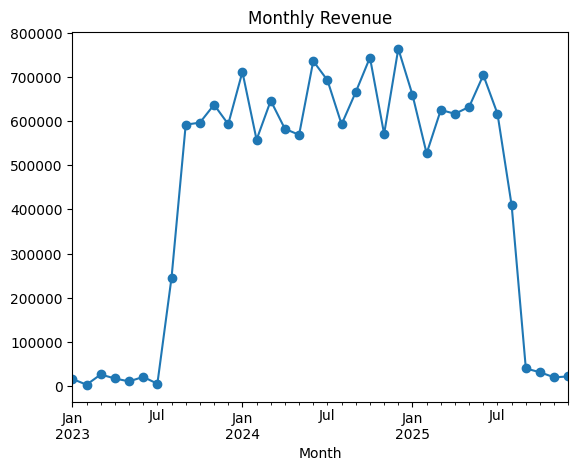

In [13]:
# Monthly revenue
df['Month'] = df['Purchase_Date'].dt.to_period('M')
monthly_rev = df.groupby('Month')['Total_Price'].sum()

# Plot
monthly_rev.plot(kind='line', marker='o', title='Monthly Revenue')

plt.show()

#### Category-wise revenue

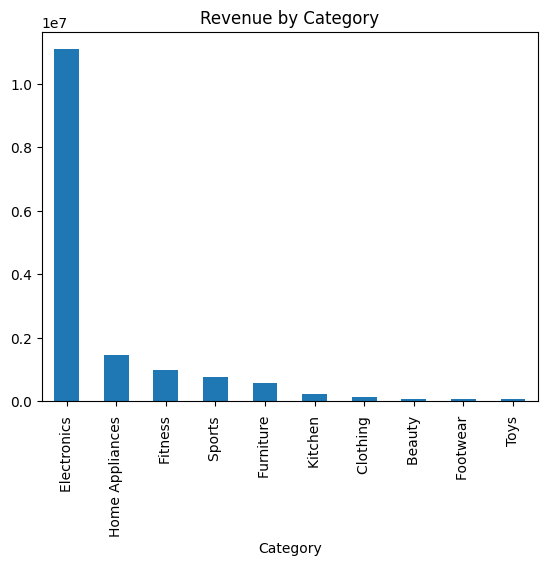

In [14]:
cat_rev = df.groupby('Category')['Total_Price'].sum().sort_values(ascending=False)
cat_rev.plot(kind='bar', title='Revenue by Category')
plt.show()

### Market Basket Analysis (Apriori)  
The goal here is to uncover **products that are frequently bought together**.  
This is useful for cross-selling, product bundling, and store layout decisions.


In [15]:
# =======================
# 1. Sample Input (replace with your df)
# =======================
# Group into baskets (list of products per customer/date)
basket = (df.groupby(['Customer_ID','Purchase_Date'])['Product']
            .apply(list)
            .reset_index())

# =======================
# 2. One-hot encode transactions
# =======================
te = TransactionEncoder()
te_ary = te.fit(basket['Product']).transform(basket['Product'])
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# =======================
# 3. Apply Apriori
# =======================
frequent_itemsets = apriori(basket_df, min_support=0.001, use_colnames=True)
print("Top Frequent Itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))


Top Frequent Itemsets:
      support                             itemsets
108  0.097738                ( iPhone 14 (128GB) )
60   0.097116      ( MacBook Pro 14-inch (512GB) )
43   0.092343  ( Fitness+ Subscription (Monthly) )
22   0.089230                ( Apple Watch Ultra )
106  0.088815             ( iMac 24-inch (256GB) )
20   0.088815     ( AirPods Pro (2nd Generation) )
19   0.087985                      ( AirPods Max )
58   0.087155              ( Mac Mini M2 (256GB) )
107  0.081552      ( iPad Pro (12.9-inch, 256GB) )
59   0.080722           ( MacBook Air M2 (256GB) )


**Insights:**  
- The Apriori algorithm identifies **frequent itemsets** (products often purchased together).  
- These insights can directly support:  
  - **Cross-selling campaigns** (suggesting related items at checkout).  
  - **Promotions** (bundling popular item pairs).  
  - **Store layout optimization** (placing commonly bought items closer together).  


### Association Rules (Apriori)  
From frequent itemsets, we now generate **association rules**.  
These rules uncover product relationships using **support, confidence, and lift**.


In [16]:
# =======================
# 4. Generate Rules
# =======================
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Filter: confidence > 0.2 and lift > 1.2
strong_rules = rules[(rules['confidence'] > 0.2) & (rules['lift'] > 1.2)]

# =======================
# 5. Show Top 10 Rules
# =======================
top_rules = strong_rules.sort_values(
    ['lift','confidence','support'], ascending=False
).head(10)

top_rules[['antecedents','consequents','support','confidence','lift']]


,antecedents,consequents,support,confidence,lift
290,"( Dri-FIT Legend Training T-Shirt , Mac Mini ...",( iPhone 14 (128GB) ),0.001245,0.315789,3.230976
255,"( Air Zoom Pegasus 39 Running Shoes , MacBook...",( Fitness+ Subscription (Monthly) ),0.001038,0.263158,2.849793
253,"( Fitness+ Subscription (Monthly) , Air Zoom ...",( MacBook Air M2 (256GB) ),0.001038,0.217391,2.693081
287,"( iPhone 14 (128GB) , MacBook Pro 14-inch (51...",( Apple Watch Ultra ),0.001453,0.212121,2.377237
289,"( Dri-FIT Legend Training T-Shirt , iPhone 14...",( Mac Mini M2 (256GB) ),0.001245,0.206897,2.373892
263,"( AirPods Max , iPad Pro (12.9-inch, 256GB) )",( MacBook Pro 14-inch (512GB) ),0.001245,0.206897,2.130416


**Insights:**  
- Each rule shows a relationship between products (`antecedents → consequents`).  
- **Support**: how often the itemset occurs in the data.  
- **Confidence**: the likelihood of buying Y given X.  
- **Lift**: how much more likely X and Y are bought together compared to random chance.

### Visualizing Association Rules  
Scatter plot of **Support vs. Confidence** with **Lift as color**.  
This helps identify the most valuable rules: high support, high confidence, and strong lift.


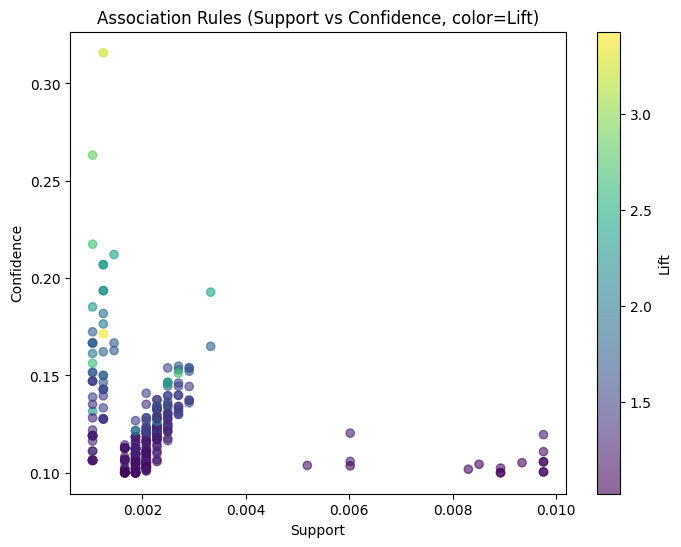

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules (Support vs Confidence, color=Lift)')
plt.show()



**Insights:**  
- Rules in the **top-right corner** (high support + high confidence) represent the strongest product associations.  
- The **color scale (Lift)** shows how much stronger the rule is compared to random chance.  
- This visualization makes it easy to spot high-impact cross-sell opportunities.  


### Visualizing Top 10 Association Rules by Lift
Horizontal bar plot of **Top 10 Rules** with **Lift** as the metric.  
This helps highlight the most influential rules for cross-selling opportunities.


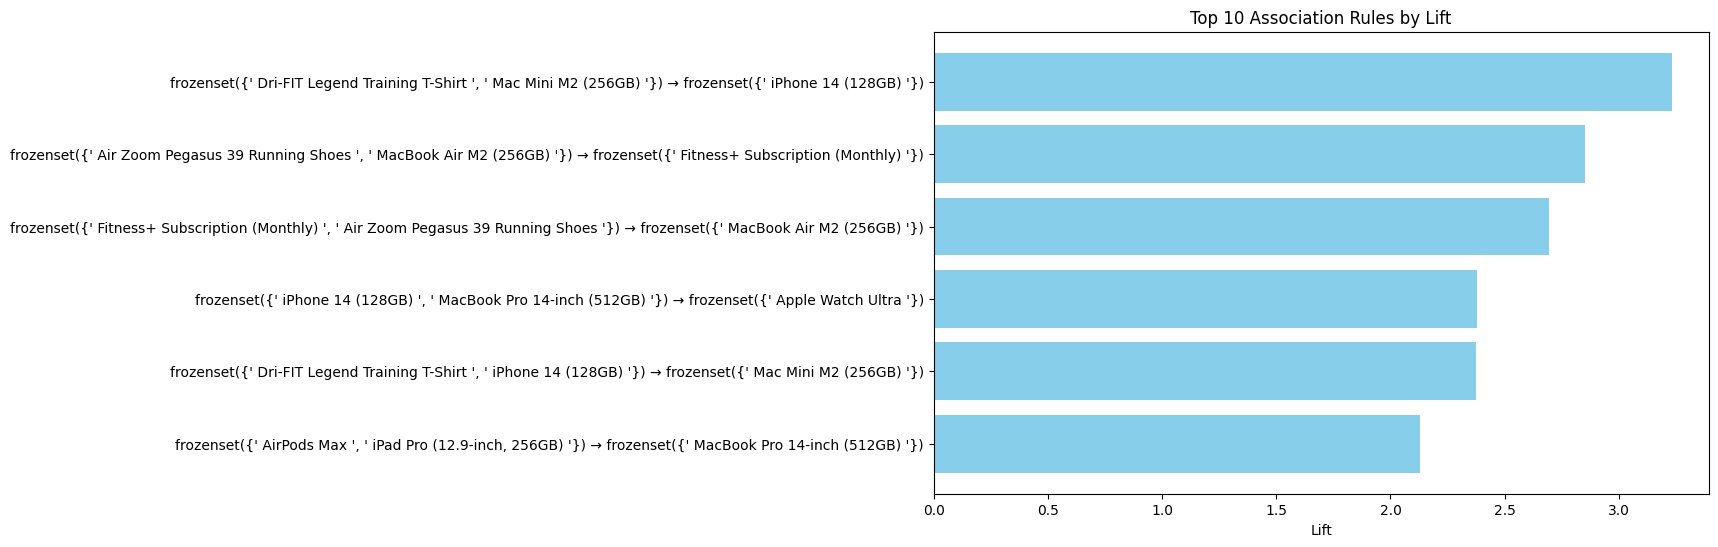

In [18]:
plt.figure(figsize=(10,6))
top_rules_plot = top_rules.copy()
top_rules_plot['rule'] = top_rules_plot['antecedents'].astype(str) + " → " + top_rules_plot['consequents'].astype(str)
plt.barh(top_rules_plot['rule'], top_rules_plot['lift'], color="skyblue")
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.gca().invert_yaxis()
plt.show()

**Insights:**  
- **Higher Lift values** indicate stronger associations between antecedent and consequent products.  
- **Top rules** are easy to spot on this horizontal bar chart, showing which product combinations are most likely to occur together.  
- Useful for **targeted promotions, bundling, and cross-selling strategies**.


### Customer Lifetime Value (CLV)
Bar plot of **Top 10 Customers** by total spending.


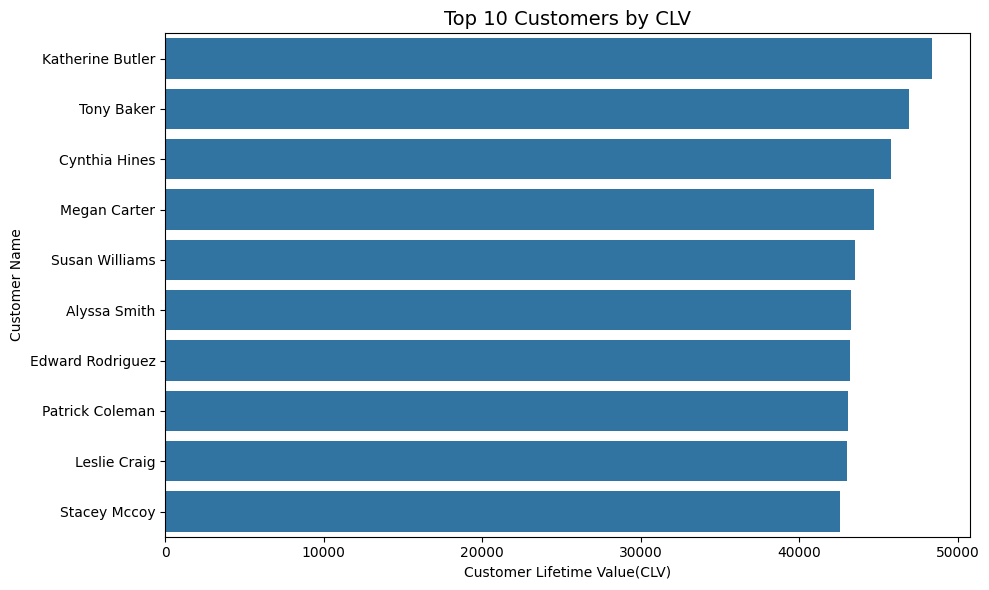

In [19]:
clv = df.groupby(['Customer_ID','Name'])['Total_Price'].sum().reset_index(name='CLV')

top_customers = clv.sort_values('CLV', ascending=False).head(10)

# 3. Plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_customers, x='CLV', y='Name', legend=False)

plt.xlabel("Customer Lifetime Value(CLV)")
plt.ylabel("Customer Name")
plt.title("Top 10 Customers by CLV",fontsize=14)
plt.tight_layout()
plt.show()


**Insights:**  
- Customers at the top are the **highest-value** in terms of spending.  
- Useful for planning **retention campaigns** and **personalized marketing**.  
- Provides a clear view of who contributes most to overall revenue.


## Monthly Sales Trend
Line plot showing **total revenue per month**.  
This helps track sales performance over time and identify trends or seasonal patterns.


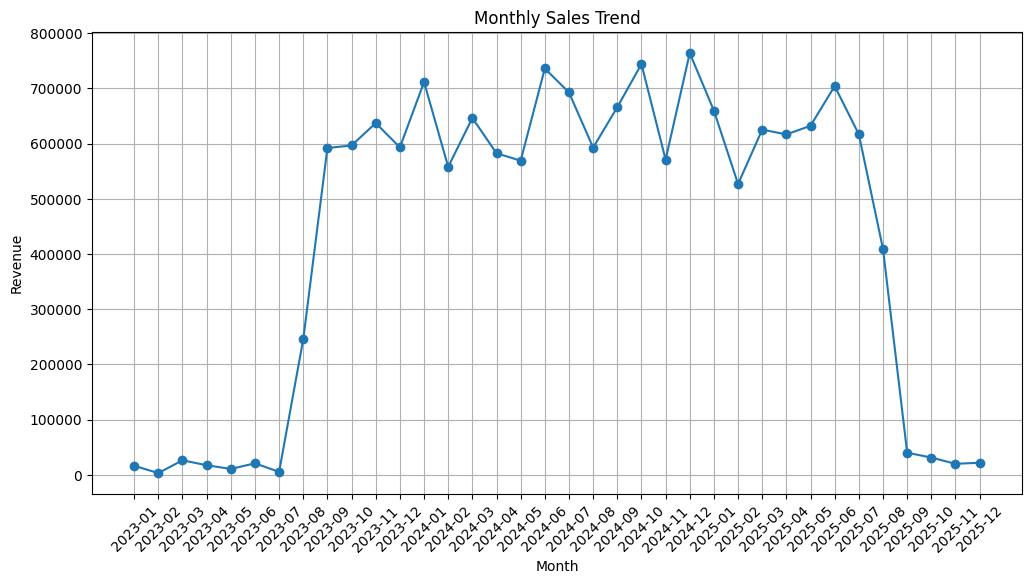

In [20]:
# Convert to datetime if not already
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])

# Monthly Sales Trend
monthly_sales = df.groupby(df['Purchase_Date'].dt.to_period('M'))['Total_Price'].sum().reset_index()
monthly_sales['Purchase_Date'] = monthly_sales['Purchase_Date'].astype(str)

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Purchase_Date'], monthly_sales['Total_Price'], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


**Insights:**  
- Shows how **revenue changes month to month**.  
- Helps spot **growth trends, dips, or seasonal patterns**.  
- Useful for **sales planning** and tracking overall business performance.


## RFM Analysis (Recency, Frequency, Monetary)
RFM analysis helps segment customers based on **how recently**, **how often**, and **how much** they purchase.  

In [21]:
# RFM (Recency, Frequency, Monetary)
# Snapshot date = day after the last purchase
snapshot_date = df['Purchase_Date'].max() + pd.Timedelta(days=1)

# Group data by Customer
customer_group = df.groupby('Customer_ID')

# ----- Recency -----
recency = customer_group['Purchase_Date'].max().apply(lambda x: (snapshot_date - x).days)

# ----- Frequency -----
frequency = customer_group['Transaction_ID'].unique().count()

# ----- Monetary -----
monetary = customer_group['Total_Price'].sum()

rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

rfm.head()


# Quick segmentation: quartiles
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# RFM Score
rfm['RFM_Score'] = rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
Customer_ID,,,,,,,
1000,474,976,7229.95,1,1,1,3
1001,405,976,14826.91,1,1,3,5
1002,133,976,13210.99,4,1,2,7
1003,236,976,33667.47,2,1,4,7
1004,131,976,3337.98,4,1,1,6


**Insights:**  
- **Recency:** Lower days indicate more recent purchases.  
- **Frequency:** Higher values indicate more frequent buyers.  
- **Monetary:** Higher values show higher spending customers.  
- **RFM Score** combines these metrics to identify **top-value customers** for marketing and retention strategies.


## Top 10 Products by Revenue
Bar plot showing the **top 10 products** generating the highest revenue.  


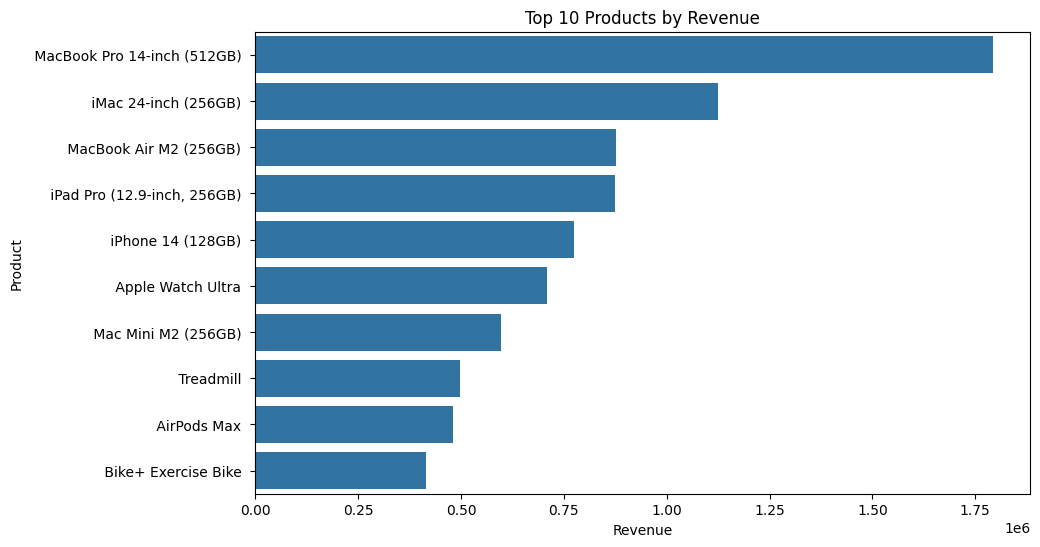

In [22]:
# Top Products by Revenue
top_products = df.groupby('Product')['Total_Price'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=top_products.head(10), x='Total_Price', y='Product')
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()


## Pareto Analysis (80/20 Rule)
Line plot showing the **cumulative revenue contribution** of products.  
This helps identify the small subset of products that generate most of the revenue.


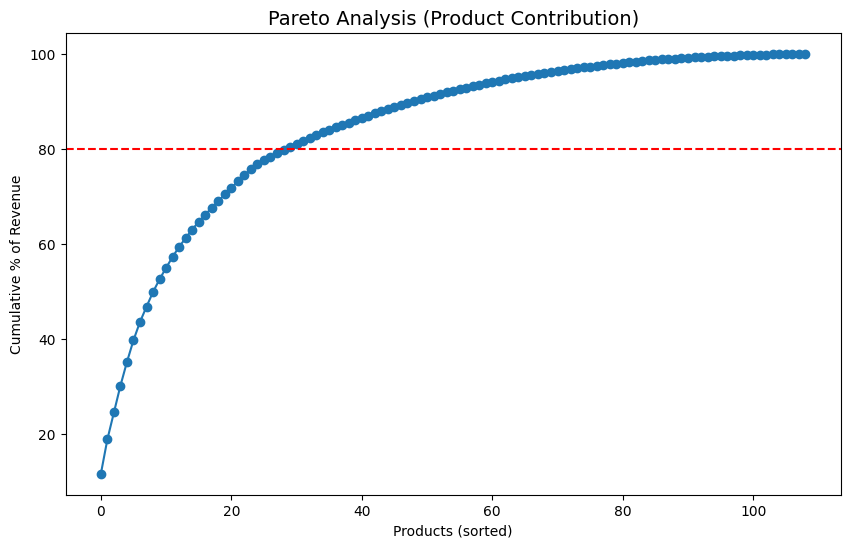

In [23]:
# Pareto (80/20 Rule)
top_products['cum_pct'] = top_products['Total_Price'].cumsum() / top_products['Total_Price'].sum() * 100
plt.figure(figsize=(10,6))
plt.plot(top_products.index, top_products['cum_pct'], marker='o')
plt.axhline(80, color='red', linestyle='--')
plt.title("Pareto Analysis (Product Contribution)",fontsize=14)
plt.xlabel("Products (sorted)")
plt.ylabel("Cumulative % of Revenue")
plt.show()


**Insights:**  
- Shows how a **small number of products contribute most of the revenue**.  
- The red dashed line at 80% highlights the **80/20 rule** in action.  
- Useful for **focusing efforts on key products** for sales and inventory optimization.


### Cohort Analysis - Customer Retention
Heatmap showing **customer retention over the first 12 months** by cohort.  
This helps track how well customers continue to engage after their initial purchase.


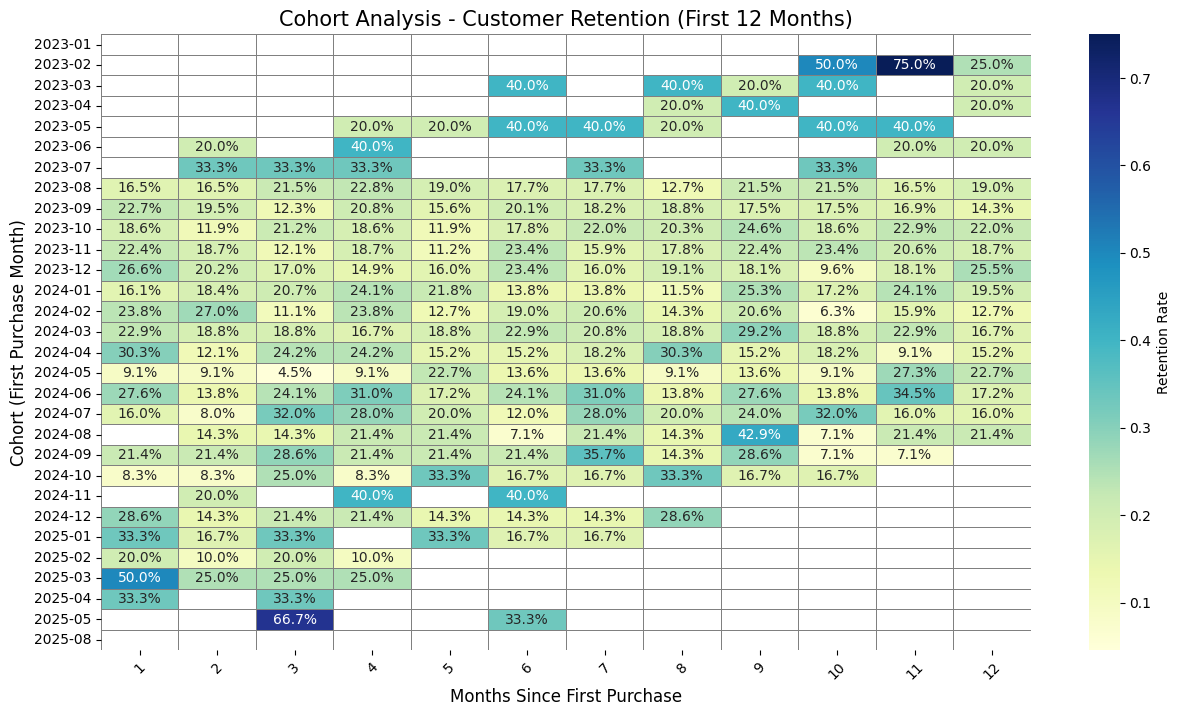

In [24]:
# Prepare Cohort Data
df['OrderMonth'] = df['Purchase_Date'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer_ID')['Purchase_Date'].transform('min').dt.to_period('M')
df['CohortIndex'] = (df['OrderMonth'].astype('int') - df['CohortMonth'].astype('int'))

# Cohort Counts
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer_ID'].nunique().reset_index()

# Pivot table
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer_ID')

# Retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# Plot: Heatmap (first 12 months only)
plt.figure(figsize=(15,8))
sns.heatmap(retention.iloc[:, 1:13], annot=True, fmt=".1%", cmap="YlGnBu", linecolor='gray', linewidths=0.5, cbar_kws={'label': 'Retention Rate'})
plt.title("Cohort Analysis - Customer Retention (First 12 Months)",fontsize=15)
plt.ylabel("Cohort (First Purchase Month)",fontsize=12)
plt.xlabel("Months Since First Purchase",fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


**Insights:**  
- Each row represents a **cohort of customers** based on their first purchase month.  
- Values show the **percentage of retained customers** over the first 12 months.  
- Helps identify **loyalty trends** and areas to improve **customer retention**.  
- Using the first 12 months makes the heatmap **clearer and easier to interpret**.


## Final Conclusions  

- This dataset was **synthetically generated** using Python (`faker`, `random`, `numpy`) to simulate **5,000 transactions** across **1,000 customers**.  
- **Data cleaning** was necessary due to intentionally messy entries:
  - Multiple date formats  
  - Inconsistent customer name formatting (uppercase, lowercase, blanks)  
  - Missing or irregular product quantities  
- Analysis revealed that sales were spread across **multiple categories**, not only electronics:
  - **Electronics** (Apple, Samsung, Sony) had the largest share due to weighted product popularity.  
  - **Footwear** (Nike, Adidas), **Home Appliances** (Dyson, KitchenAid), **Sports & Fitness** (Fitbit, Peloton, Garmin), and **Beauty & Clothing** (Clinique, Levi’s, Nike apparel) also contributed significantly.  
  - Popular items included **iPhone 14, PlayStation 5, Nike Air Force 1 Sneakers, and KitchenAid mixers**.  
- Visualizations showed **brand-driven sales concentration** and highlighted **multi-category contributions**, uncovering trends across industries.  

---

## Limitations  

- The dataset is **artificially generated**, so insights cannot be applied to real-world business contexts.  
- **Product popularity bias** was built into the generator (e.g., Apple and Nike appear more often), skewing category distribution.  
- Customer records lack demographics such as age, gender, or location.  
- No financial information (discounts, returns, profit margins) was included.  
- Dates were randomized across two years without seasonality or marketing campaign effects.  

---

## Final Thoughts  

This project successfully demonstrated how to:  
- Create **synthetic but realistic datasets** for e-commerce analysis.  
- Perform **data cleaning, preprocessing, and exploratory analysis** on messy data.  
- Visualize and interpret sales patterns to understand **key drivers of performance**.  

>  While the dataset is artificial, the **workflow reflects real-world analytics pipelines**, making it a valuable exercise in **data wrangling, visualization, and business insight generation**.  
